<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/X-CLIP/Zero_shot_classify_a_YouTube_video_with_X_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

We first install 🤗 Transformers, decord and pytube.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git decord

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 13.6 MB 34.6 MB/s 
     |████████████████████████████████| 120 kB 61.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 


In [2]:
!pip install -q pytube

     |████████████████████████████████| 56 kB 4.1 MB/s 


## Load video

Here you can provide any YouTube video you like! Just provide the URL :) in my case, I'm providing a YouTube video of Karpathy teaching neural networks.

In [3]:
from pytube import YouTube

youtube_url = 'https://youtu.be/VMj-3S1tku0'
yt = YouTube(youtube_url)

streams = yt.streams.filter(file_extension='mp4')
print(streams)

[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">, <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">, <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d4015" progressive="False" type="video">, <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c" progressive="False" type="video

In [4]:
len(streams)

10

In [5]:
file_path = streams[0].download()

## Sample frames

The X-CLIP model we'll use expects 32 frames for a given video. Let's sample them:

In [6]:
from decord import VideoReader, cpu
import torch
import numpy as np

from huggingface_hub import hf_hub_download

np.random.seed(0)

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 32 frames
videoreader.seek(0)
indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=len(videoreader))
video = videoreader.get_batch(indices).asnumpy()

In [7]:
video.shape

(32, 360, 640, 3)

Let's visualize the first of the 32 frames!

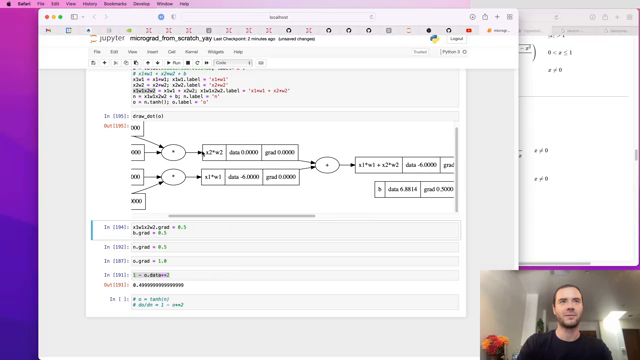

In [8]:
from PIL import Image

Image.fromarray(video[0])

## Load X-CLIP model

Let's instantiate the XCLIP model, along with its processor.

In [9]:
from transformers import XCLIPProcessor, XCLIPModel

model_name = "microsoft/xclip-base-patch16-zero-shot"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/927 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780M [00:00<?, ?B/s]

## Zero-shot classification

Usage of X-CLIP is identical to CLIP: you can feed it a bunch of texts, and the model determines which ones go best with the video.

In [10]:
import torch

inputs = processor(text=["programming course", "eating spaghetti", "playing football"], videos=list(video), return_tensors="pt", padding=True)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

probs = outputs.logits_per_video.softmax(dim=1)
probs

tensor([[9.9693e-01, 3.0005e-03, 6.9975e-05]])